In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjust path if the package is not installed
import sys
sys.path.append('.')  # Assumes root contains battery_ocv_toolbox/
# Import the package
from ocv_teaching import OCV, ActiveMaterial, OCVBlending, CellOCVReconstruction
from ocv_teaching.plot_ocv import plot_ocv
from ocv_teaching.utils import interpolate, new_plot

In [3]:
NCM811_df = pd.read_csv('../ocv_data/NMC811_half_cell_ocv.csv')
Graphite_df = pd.read_csv('../ocv_data/Graphite_half_cell_ocv.csv')

In [4]:
NCM811_ocv = OCV(NCM811_df["SOC"], NCM811_df["Voltage"], NCM811_df["Voltage"])
Graphite_ocv = OCV(Graphite_df["SOC"], Graphite_df["Voltage"], Graphite_df["Voltage"])
NCM811_mat = ActiveMaterial(NCM811_ocv, specific_capacity=212, formation_loss=0.09)
Graphite_mat = ActiveMaterial(Graphite_ocv, specific_capacity=372, formation_loss=0.08)


Plot OCVs vs capacity normalized

C:\Users\Lvk\AppData\Local\Temp\ipykernel_29160\1831205962.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='right')


ValueError: cannot find widget or abbreviation for argument: 'ax'

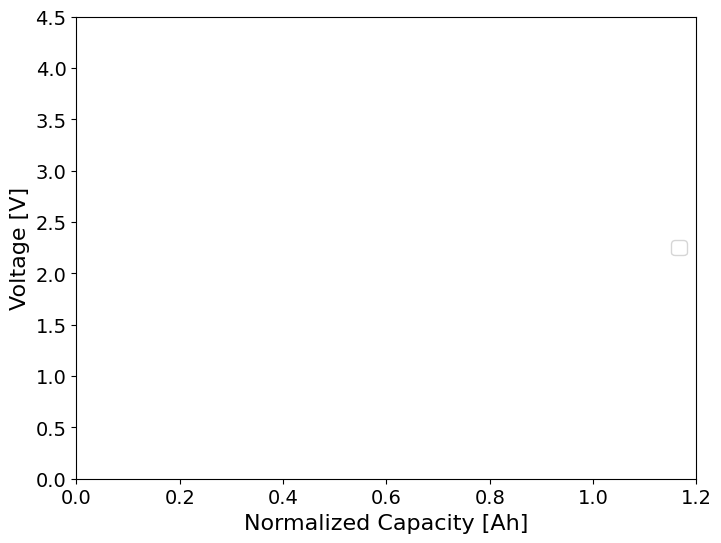

In [ ]:

from ipywidgets import interact, FloatSlider
def plot_np_ratio(ax,np_ratio,v_min,v_max):
    cell = CellOCVReconstruction(NCM811_mat, Graphite_mat, np_ratio=np_ratio, v_min=v_min, v_max=v_max)

    # Reconstruct voltage of the cell over the full range
    an0_full = cell.align_anode_cathode(1)
    an1_full = cell.align_anode_cathode(0)
    volt_cell_full  = cell.reconstruct_voltage(
        an0_full, 1, an1_full, 0, direction="discharge"
    )[0]
    # Get stoichiometeries within voltage limits
    an0, cath0, an1, cath1 = cell.get_stoichiometries()
    sol = np.linspace(0,1,100)
    # Relate anode to cathode stoichiometry
    sol_an_plot = (sol-an0_full)/(an1_full-an0_full)
    volt_cath = interpolate(cell.cath.ocv.soc, cell.cath.ocv.get_voltage("charge"), sol)
    volt_an = interpolate(cell.an.ocv.soc, cell.an.ocv.get_voltage("charge"), sol)

    # Plot the results
    fig, ax = new_plot(figsize=(8, 6))
    ax.set_xlim(0,1.2)
    ax.set_ylim(0,4.5)
    ax.set_ylabel("Voltage [V]")
    ax.set_xlabel("Normalized Capacity [Ah]")
    ax.grid()
    ax.legend(loc='right')
    ax.plot(sol_an_plot , volt_an, label="Graphite OCV")
    ax.plot(1-sol, volt_cath, label="NCM811 OCV")
    ax.plot(sol,volt_cell_full, label="Cell OCV", color='green')
    ax.hlines([v_min, v_max], 0, 1.2, linestyles='dashed', colors='black')
    ax.plot([1-cath0,1-cath1],[v_min,v_max],marker="o", color='green',linestyle='None')

    ## Draw the usage span
    # compute the x‑coordinates of the usage span
    start = 1 - cath0
    end   = 1 - cath1
    mid   = 0.5*(start + end)
    usage = cath0 - cath1

    # draw a double‑headed arrow at y=3
    ax.annotate(
        '',                          # no text
        xy=(end, 3),                 # arrow head at right
        xytext=(start, 3),           # arrow tail at left
        arrowprops=dict(
            arrowstyle='<->',        # double‑headed
            color='black',
            lw=2
        )
    )

    # label it just above the arrow
    ax.text(
        mid, 3.05,                   # position (slightly above y=3)
        f'Cathode usage = {usage:.3f}',
        ha='center', va='bottom',
        color='black'
    )
    plt.show()

interact(
    plot_np_ratio,
    np_ratio=FloatSlider(min=0.9, max=1.2, step=0.01, value=1.1, description="N:P Ratio"),
    v_min=FloatSlider(min=2, max=3.6, step=0.01, value=2.8, description="Lower voltage limit"),
    v_max=FloatSlider(min=3.6, max=4.2, step=0.01, value=4.2, description="Upper voltage limit"),
)

In [ ]:

# Precompute basic functions and vectors
an0_bol, cath0_bol, an1_bol, cath1_bol =cell.get_stoichiometries()  # This will compute an0, cath0, an1, cath1
# Reconstruct voltages (use "discharge" or "charge" as desired)
volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
    an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
)

volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
    an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
)


sol_cath = np.linspace(0,1,100)
sol_an = np.linspace(0,1,100)
volt_cath = interpolate(cell.cath.ocv.soc, cell.cath.ocv.get_voltage("charge"), sol_cath)
volt_an = interpolate(cell.an.ocv.soc, cell.an.ocv.get_voltage("charge"), sol_an)


volt_cell_cha = cell.reconstruct_voltage(an0,1,an1,0,direction="charge")[0]
plt.plot(sol_an_plot , volt_an, label="Graphite OCV")
plt.plot(1-sol_cath, volt_cath, label="NCM811 OCV")
plt.plot(sol_an_plot,volt_cell_cha, label="Cell OCV (charge)", color='black', linestyle='--')

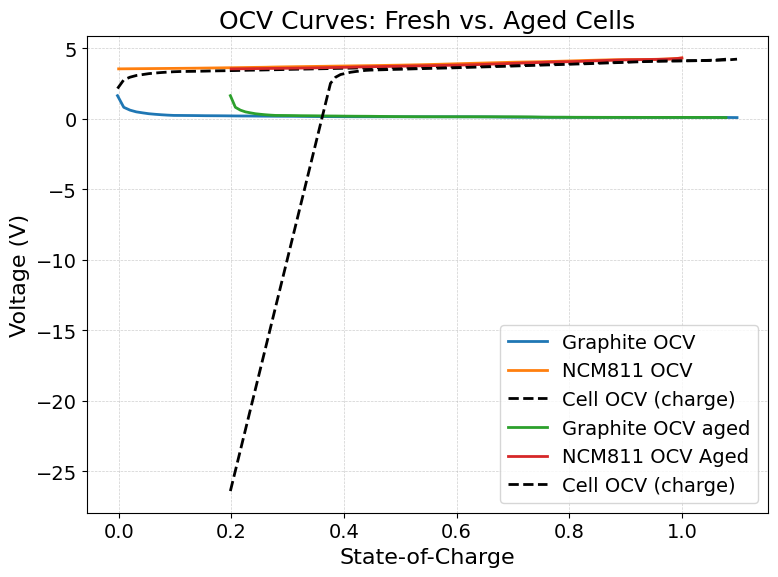

In [ ]:


LAMPE = 0.2
LAMNE = 0.2
LLI = 0.2
np_aged = cell.np_ratio*(1-LAMNE)
np_offset_aged = 1-(1-cell.np_offset)*(1-LLI)
an0 = cell.align_anode_cathode(1,np_aged, np_offset_aged)
an1 = cell.align_anode_cathode(0,np_aged, np_offset_aged)
sol_an_aged = (sol_cath-an0)/(an1-an0)
volt_cell_cha_aged = cell.reconstruct_voltage(an0,1,an1,0,direction="charge")[0]

plt.plot(sol_an_aged , volt_an, label="Graphite OCV aged")
plt.plot((1-sol_cath*(1-LAMPE)), volt_cath, label="NCM811 OCV Aged")
plt.plot(sol_an_aged,volt_cell_cha_aged, label="Cell OCV (charge)", color='black', linestyle='--')
plt.xlabel("State-of-Charge")               # clearer x-axis label
plt.ylabel("Voltage (V)")
plt.title("OCV Curves: Fresh vs. Aged Cells")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(frameon=True, loc='best')
plt.tight_layout()
plt.show()



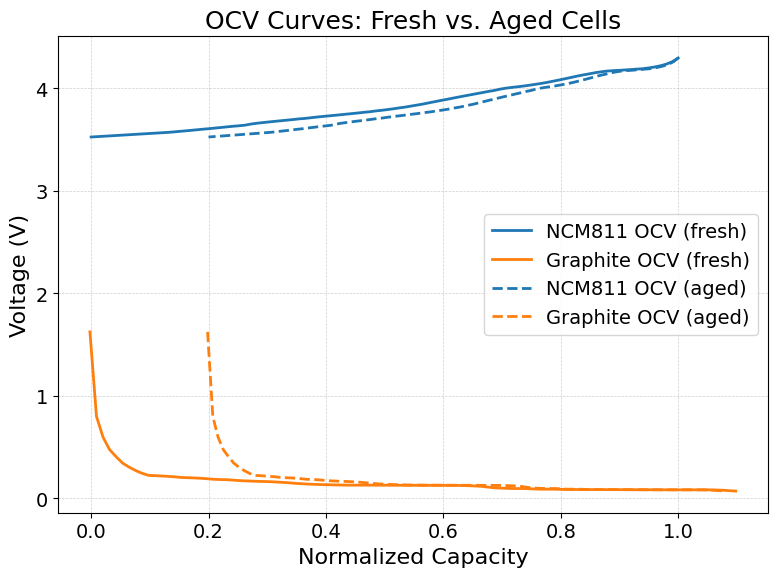

In [6]:
import matplotlib.pyplot as plt

# … [your data-calculation code stays exactly the same] …

# Define consistent colors
cath_color = "#1f77b4"   # blue
an_color   = "#ff7f0e"   # orange
lw = 2.0

# Plot fresh curves
plt.plot(1 - sol_cath, volt_cath, label="NCM811 OCV (fresh)",
         color=cath_color, linewidth=lw, linestyle='-')
plt.plot(sol_an_plot, volt_an, label="Graphite OCV (fresh)",
         color=an_color, linewidth=lw, linestyle='-')

# Plot aged curves
plt.plot((1 - sol_cath * (1 - LAMPE)), volt_cath, label="NCM811 OCV (aged)",
         color=cath_color, linewidth=lw, linestyle='--')
plt.plot(sol_an_aged, volt_an, label="Graphite OCV (aged)",
         color=an_color, linewidth=lw, linestyle='--')

# Styling
plt.xlabel("Normalized Capacity")               # clearer x-axis label
plt.ylabel("Voltage (V)")
plt.title("OCV Curves: Fresh vs. Aged Cells")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(frameon=True, loc='best')
plt.tight_layout()
plt.show()


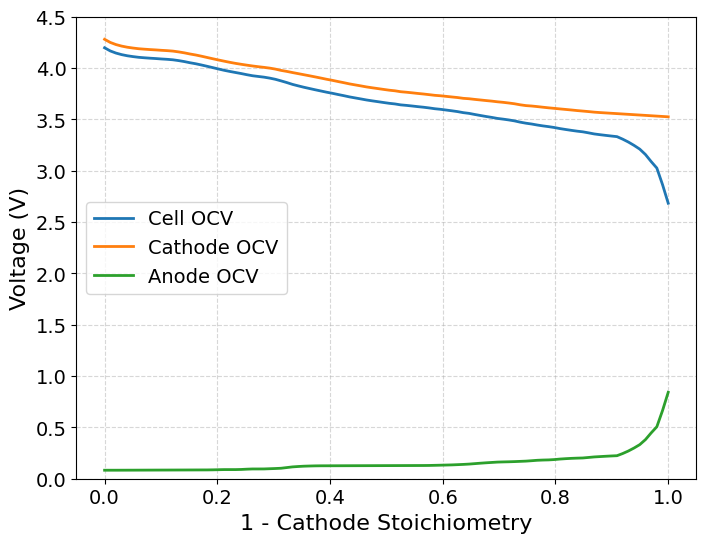

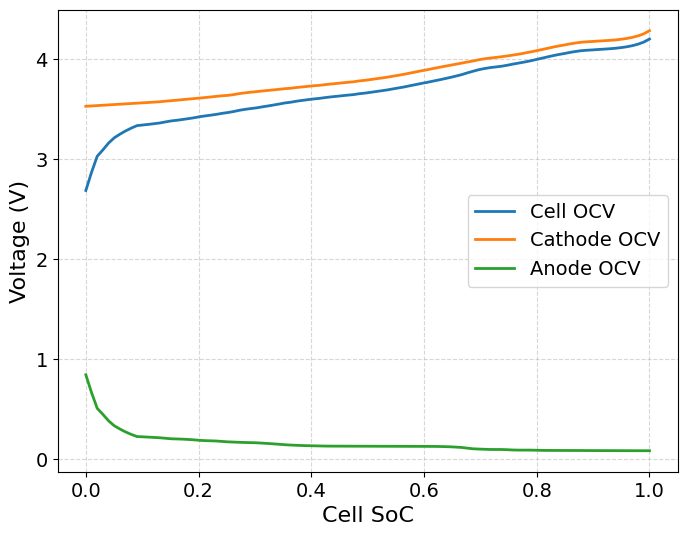

interactive(children=(FloatSlider(value=0.0, description='LAMNE', max=0.5, step=0.01), FloatSlider(value=0.0, …

<function __main__.plot_aging(LAMNE=0.1, LAMPE=0.1, LLI=0.05)>

In [7]:
# OCV Reconstruction Plots and Interactive Aging Widget
# Notebook imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# -----------------------------------------------------------------------------
# 1. Instantiate your cell
# -----------------------------------------------------------------------------
# Replace the following lines with your actual material definitions
# cath_material = ActiveMaterial(... your cathode data ...)
# an_material   = ActiveMaterial(... your anode data ...)
# np_ratio      = 1.1  # e.g. N:P ratio

cell = CellOCVReconstruction(NCM811_mat, Graphite_mat, np_ratio=1.1, v_min=2.5, v_max=4.2)

# Precompute basic functions and vectors
soc_vec = np.linspace(0, 1, 100)
an0_bol, cath0_bol, an1_bol, cath1_bol =cell.get_stoichiometries()  # This will compute an0, cath0, an1, cath1
# sol_an_fun = lambda x, np_offset=cell.np_offset, np_ratio=cell.np_ratio: (-x + 1 - np_offset) / np_ratio

# # Compute BoL (begin‐of‐life) stoichiometric endpoints
# an0_bol = sol_an_fun(0)
# an1_bol = sol_an_fun(1)
# cath0_bol = 1
# cath1_bol = 0

# Reconstruct voltages (use "discharge" or "charge" as desired)
volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
    an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
)

# -----------------------------------------------------------------------------
# 2. Plot 1: Aligned on (1 - sol_cath)
# -----------------------------------------------------------------------------
x1 = 1 - soc_vec
fig1, ax1 = new_plot()
ax1.plot(x1, volt_cell_bol, label="Cell OCV")
ax1.plot(x1, volt_cath_bol, label="Cathode OCV")
ax1.plot(x1, volt_an_bol, label="Anode OCV")
ax1.set_xlabel("1 - Cathode Stoichiometry")
ax1.set_ylabel("Voltage (V)")
ax1.set_ylim(0, 4.5)
ax1.legend()
plt.show()

# -----------------------------------------------------------------------------
# 3. Plot 2: Aligned on cell SoC
# -----------------------------------------------------------------------------
fig2, ax2 = new_plot()
ax2.plot(soc_vec, volt_cell_bol, label="Cell OCV")
ax2.plot(soc_vec, volt_cath_bol, label="Cathode OCV")
ax2.plot(soc_vec, volt_an_bol, label="Anode OCV")
ax2.set_xlabel("Cell SoC")
ax2.set_ylabel("Voltage (V)")
ax2.legend()
plt.show()

# -----------------------------------------------------------------------------
# 4. Plot 3: Interactive Aging Modes
# -----------------------------------------------------------------------------
def plot_aging(LAMNE=0.1, LAMPE=0.1, LLI=0.05):
    an0_bol, cath0_bol, an1_bol, cath1_bol = cell.get_stoichiometries()
    # BoL curves (dashed)
    volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
        an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
    )

    # Aged endpoints & curves
    
    an0_aged, cath0_aged, an1_aged, cath1_aged = cell.simulate_aging_modes(LAMPE, LAMNE, LLI)
    volt_cell_aged, volt_cath_aged, volt_an_aged = cell.reconstruct_voltage(
        an0_aged, cath0_aged, an1_aged, cath1_aged, direction="discharge"
    )

    # Plot
    fig, ax = new_plot()
    # BoL
    ax.plot(x1, volt_cell_bol, "--", label="Cell OCV BoL")
    ax.plot(x1, volt_cath_bol, "--", label="Cathode OCV BoL")
    ax.plot(x1, volt_an_bol, "--", label="Anode OCV BoL")
    # Aged
    ax.plot(x1, volt_cell_aged, label="Cell OCV Aged")
    ax.plot(x1, volt_cath_aged, label="Cathode OCV Aged")
    ax.plot(x1, volt_an_aged, label="Anode OCV Aged")

    ax.set_xlabel("1 - Cathode Stoichiometry")
    ax.set_ylabel("Voltage (V)")
    ax.set_ylim(0, 4.5)
    ax.legend()
    plt.show()

# Widget to vary LAMNE, LAMPE, LLI interactively
interact(
    plot_aging,
    LAMNE=FloatSlider(min=0, max=0.5, step=0.01, value=0.0, description="LAMNE"),
    LAMPE=FloatSlider(min=0, max=0.5, step=0.01, value=0.0, description="LAMPE"),
    LLI=FloatSlider(min=0, max=0.5, step=0.01, value=0.0, description="LLI"),
)
